# Evaluate each possible single mutation using zero shot methods

In [1]:
from aide_predict.utils.common import get_supported_tools

In [2]:
get_supported_tools()

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


HMMWrapper: AVAILABLE
ESM2LikelihoodWrapper: AVAILABLE
MSATransformerLikelihoodWrapper: AVAILABLE
EVMutationWrapper: AVAILABLE
SaProtLikelihoodWrapper: AVAILABLE
ESM2Embedding: AVAILABLE
OneHotAlignedEmbedding: AVAILABLE
OneHotProteinEmbedding: AVAILABLE
MSATransformerEmbedding: AVAILABLE
SaProtEmbedding: AVAILABLE



'HMMWrapper: AVAILABLE\nESM2LikelihoodWrapper: AVAILABLE\nMSATransformerLikelihoodWrapper: AVAILABLE\nEVMutationWrapper: AVAILABLE\nSaProtLikelihoodWrapper: AVAILABLE\nESM2Embedding: AVAILABLE\nOneHotAlignedEmbedding: AVAILABLE\nOneHotProteinEmbedding: AVAILABLE\nMSATransformerEmbedding: AVAILABLE\nSaProtEmbedding: AVAILABLE\n'

Currently available zero shot methods:
1. ESM2
2. HMM (requires MSA)
3. EVMutation (Requires MSA)
4. MSATransformer (requires MSA)
5. SaProt (Requires structure)

## Here we use kinase EnvZ
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10160972/

For demo purposes, a small MSA was created using HHfilter from the EnvZ MSA.

To produce your own MSA for zero shot prediction methods that require it, you can use the [EVCouplings pipeline](https://github.com/debbiemarkslab/EVcouplings), which is a dependancy of `aide_predict` and can be imported as `from evcouplings.align.protocol import  standard as evcouplings_pipeline` and run locally. You may also use any other MSA server like jackhmmer or psi-blast on EBI or NCBI.

In [3]:
import os
import pandas as pd

# protein specific data sctructures
from aide_predict.utils.data_structures import ProteinSequence, ProteinSequencesOnFile, ProteinSequences, ProteinStructure

# the models we will test
from aide_predict.bespoke_models import (
    MSATransformerLikelihoodWrapper,
    ESM2LikelihoodWrapper,
    SaProtLikelihoodWrapper,
    EVMutationWrapper
)

# tools for plotting
from matplotlib import pyplot as plt
import seaborn as sns
from aide_predict.utils.plotting import plot_protein_sequence_heatmap
sns.set_style("whitegrid")
sns.set_context("talk")

### Define the wild type sequence and the MSA

In [4]:
wt = ProteinSequence(
    "LADDRTLLMAGVSHDLRTPLTRIRLATEMMSEQDGYLAESINKDIEECNAIIEQFIDYLR",
    id='ENVZ_ECOLI/1-60',
    structure=ProteinStructure(os.path.join('..', 'tests', 'data', 'ENVZ_ECOLI.pdb'))
)
msa = ProteinSequencesOnFile.from_fasta(os.path.join('data', 'ENVZ_ECOLI_extreme_filtered.a2m'))

### Define and fit the models

__PLEASE NOTE THE DEVICE PARAMETER__: This notebook was written on apple silico so I use MPS, if you have a GPU change it to `cuda`. If you have no vector hardware, you have to use `cpu` ... good luck out there.

In [5]:
msat = MSATransformerLikelihoodWrapper(
    pool=True, # we want the scores to be averaged over the whole protein
    metadata_folder='msat', # required for the API, but MSATransformer does not use it
    wt=wt,
    marginal_method='wildtype_marginal',
    device="mps"
)
msat.fit(msa)

This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.


MSATransformerLikelihoodWrapper(device='mps',
                                marginal_method='wildtype_marginal',
                                metadata_folder='msat',
                                wt=ProteinSequence(id='ENVZ_ECOLI/1-60', seq='LADDRTLLMAGVSHDLRTPL...'))

In [6]:
evm = EVMutationWrapper(
    wt=wt,
    metadata_folder='evm'
)
evm.fit(msa)

EVMutationWrapper(metadata_folder='evm',
                  wt=ProteinSequence(id='ENVZ_ECOLI/1-60', seq='LADDRTLLMAGVSHDLRTPL...'))

In [7]:
saprot = SaProtLikelihoodWrapper(
    wt=wt,
    marginal_method='wildtype_marginal',
    device='mps',
    metadata_folder='saprot'
)
saprot.fit(ProteinSequences([])) # model does not need a MSA like the above two, it just needs WT structure

This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.


SaProtLikelihoodWrapper(device='mps', marginal_method='wildtype_marginal',
                        metadata_folder='saprot',
                        wt=ProteinSequence(id='ENVZ_ECOLI/1-60', seq='LADDRTLLMAGVSHDLRTPL...'))

In [8]:
esm2 = ESM2LikelihoodWrapper(
    wt=wt,
    marginal_method='wildtype_marginal',
    device='mps',
    metadata_folder='esm2'
)
esm2.fit(ProteinSequences([])) # model does not need a MSA like the above two, it just needs WT structure

This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.


ESM2LikelihoodWrapper(device='mps', marginal_method='wildtype_marginal',
                      metadata_folder='esm2',
                      wt=ProteinSequence(id='ENVZ_ECOLI/1-60', seq='LADDRTLLMAGVSHDLRTPL...'))

### Get a saturation mutagensis dataset

In [9]:
variants = wt.saturation_mutagenesis()

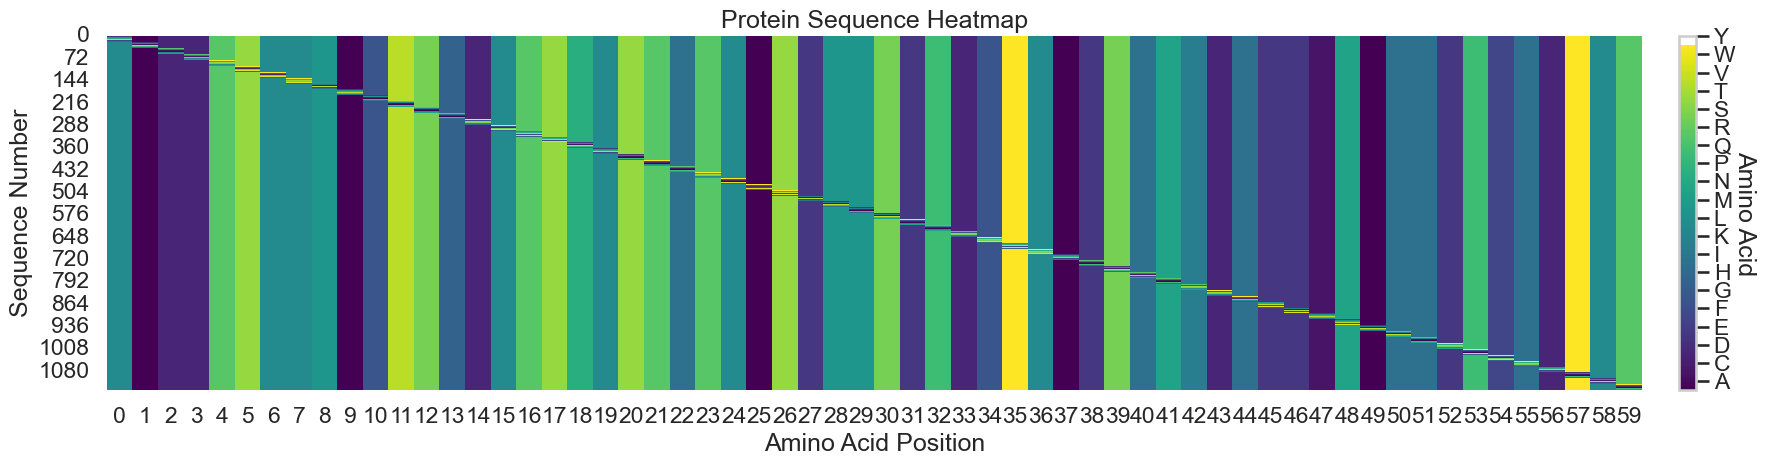

In [10]:
fig = plot_protein_sequence_heatmap(variants)

### Make predictions

In [11]:
import time

In [12]:
models = {
    'MSATransformer': msat,
    'EVMutation': evm,
    'SaProt': saprot,
    'ESM2': esm2
}
predictions = {}
for name, model in models.items():
    t1 = time.time()
    predictions[name] = model.predict(variants).flatten()
    t2 = time.time()
    print(f'{name} took {(t2-t1)/60:.2f} min')

# add the mutation ids
predictions['mutation'] = [v.id for v in variants]

# dataframe
df = pd.DataFrame(predictions)
df


MSA batches: 80it [00:48,  1.66it/s]      | 0/1 [00:00<?, ?sequence/s]
Computing log likelihoods: 100%|██████████| 1/1 [00:48<00:00, 48.09s/sequence]


MSATransformer took 0.83 min
EVMutation took 0.01 min


/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmForMaskedLM were not initialized from the model checkpoint at westlake-repl/SaProt_650M_AF2 and are newly initialized: ['esm.embeddings.position_embeddings.weight', 'esm.contact_head.regression.weight', 'esm.contact_head.regression.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00,  1.29sequence/s]


SaProt took 0.11 min


Computing log likelihoods: 100%|██████████| 1/1 [00:00<00:00,  6.10sequence/s]


ESM2 took 0.01 min


,MSATransformer,EVMutation,SaProt,ESM2,mutation
0,-6.116612,-9.411591,-8.111230,-3.485144,L1E
1,-6.301475,-9.411591,-7.460206,-3.868431,L1R
2,-6.489444,-9.411591,-9.749337,-4.934546,L1Y
3,-3.560375,-9.411591,-3.107444,0.902599,L1M
4,-6.288790,-9.411591,-8.359010,-4.054807,L1K
...,...,...,...,...,...
1135,-9.202480,-8.626774,-9.606665,-5.609511,R60L
1136,-10.597533,-8.626774,-12.380845,-8.216669,R60W
1137,-9.844908,-8.626774,-10.692245,-6.326545,R60I
1138,-7.924660,-8.626774,-9.354113,-4.319509,R60N


Higher is better - it may be worth limitting the number of mutations in a library to the top 10% of predictions.

### EXTRA: since this protein was the subject of a DMS, we can compare to true experimental values

In [13]:
labels = pd.read_csv(os.path.join('..', 'tests', 'data', 'ENVZ_ECOLI_Ghose_2023.csv'))

In [14]:
data = labels.set_index('mutant').join(df.set_index('mutation'))

In [15]:
# compute spearman correlation
correlation = data.corr(method='spearman').loc['DMS_score'].drop('DMS_score')
correlation

DMS_score_bin     0.830681
MSATransformer    0.193304
EVMutation        0.121171
SaProt            0.168231
ESM2              0.189944
Name: DMS_score, dtype: float64

<AxesSubplot: xlabel='DMS_score', ylabel='MSATransformer'>

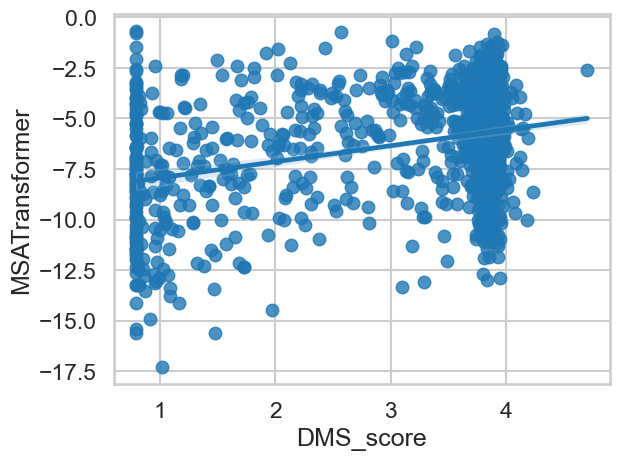

In [16]:
fig, ax = plt.subplots()
sns.regplot(data=data, x='DMS_score', y='MSATransformer', ax=ax)
